# **Data Preprocessing: Stage Four**

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import time

# Libraries for audio
from IPython.display import Audio
import librosa
import librosa.display
import IPython.display as ipd

# Training and Testing Split
from sklearn.model_selection import train_test_split

# for normalization & avgpooling features
from sklearn.preprocessing import MinMaxScaler # to squeeze all the features to be within 0 and 1
import tensorflow as tf

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.ndimage
from scipy.signal import butter, filtfilt

# Feature Extraction

Turning the data into Mel-spectrograms 

In [2]:
npy_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/train_audio_npy/'  # Path to audio npy files
save_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-4/'  # Where to save features
n_mels = 128
target_shape = (128,128)
sr = 16000

In [3]:
# Loading the train-validation split CSV
csv_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/trainval-split/stage-4-trainval-2.csv'
trainval_data = pd.read_csv(csv_path)
train_data = trainval_data[trainval_data['set'] == 'tr']
val_data = trainval_data[trainval_data['set'] == 'val']

In [9]:
train_pkl_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-4/train_features_6s.pkl'
val_pkl_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/feature-extraction/Stage-4/val_features_6s.pkl'


In [5]:
# Function to normalize audio data between 0 and 1
def normalize_audio(audio):
    return (audio - np.min(audio)) / (np.max(audio) - np.min(audio))


In [6]:
def generate_pink_noise(num_samples):
    white_noise = np.random.randn(num_samples)
    
    # Apply a filter to convert white noise into pink noise (1/f noise)
    X = np.fft.rfft(white_noise)
    S = np.arange(1, len(X) + 1)  # Frequency scaling
    pink_noise = np.fft.irfft(X / S)
    
    return normalize_audio(pink_noise)

In [7]:
# Function to pad audio with noise
def pad_with_noise(audio_data, window_length, sr=sr):
    current_length = librosa.get_duration(y=audio_data, sr=sr)
    if current_length >= window_length:
        return audio_data
    
    target_length_samples = int(window_length * sr)
    current_length_samples = len(audio_data)
    padding_length_samples = target_length_samples - current_length_samples
    
    # Generate pink noise to pad with
    pink_noise = generate_pink_noise(padding_length_samples)
    padded_audio = np.concatenate([audio_data, pink_noise])
    
    return padded_audio

In [8]:
def bandpass_filter(audio, lowcut=500, highcut=7900, sr=sr, order=4):
    nyquist = 0.5 * sr  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')
    
    # Apply filter to audio
    filtered_audio = filtfilt(b, a, audio)
    return filtered_audio

In [13]:
# Function to generate multiple features (Mel, RMS, Chroma, MFCC) with sliding window and overlap
def get_features_with_window(npy_file, filter=True, sr=sr, window_size=6, overlap=3, n_mels=128, hop_length=512, target_shape=(128, 128)):
    audio_data = np.load(npy_path + npy_file)
    audio_data = normalize_audio(audio_data)
    audio_data = pad_with_noise(audio_data, window_length=window_size)
    
    # Calculate the step and overlap in samples
    step = int(window_size * sr)
    overlap_step = int(overlap * sr)
    
    features = []  # To store feature dictionaries
    
    # Create multiple windows with overlap
    for start in range(0, len(audio_data) - step + 1, overlap_step):
        windowed_data = audio_data[start:start + step]
        if filter:
            windowed_data = bandpass_filter(windowed_data)
        
        
        # Generate Mel Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=windowed_data, sr=sr, n_mels=n_mels, hop_length=hop_length)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
        mel_resized = scipy.ndimage.zoom(mel_spec_db, (target_shape[0] / mel_spec_db.shape[0], target_shape[1] / mel_spec_db.shape[1]))
        
        # Generate RMS Energy
        rms_energy = librosa.feature.rms(y=windowed_data)
        rms_resized = scipy.ndimage.zoom(rms_energy, (target_shape[0] / rms_energy.shape[0], target_shape[1] / rms_energy.shape[1]))
        
        # Generate Chroma Frequencies
        chroma = librosa.feature.chroma_stft(y=windowed_data, sr=sr)
        chroma_resized = scipy.ndimage.zoom(chroma, (target_shape[0] / chroma.shape[0], target_shape[1] / chroma.shape[1]))
        
        # Generate MFCC
        mfcc = librosa.feature.mfcc(y=windowed_data, sr=sr, n_mfcc=13)
        mfcc_resized = scipy.ndimage.zoom(mfcc, (target_shape[0] / mfcc.shape[0], target_shape[1] / mfcc.shape[1]))
        
        # Append the feature set to the list as a dictionary
        features.append({
            "mel_spectrogram": mel_resized,
            "rms_energy": rms_resized,
            "chroma": chroma_resized,
            "mfcc": mfcc_resized
        })
    
    return features  # Returns a list of dictionaries containing all features for each window


In [14]:
def plot_all_features(npy_file, window_idx, filter=True, sr=sr, window_size=6, overlap=3, n_mels=128, hop_length=512, target_shape=(128, 128)):
    audio_data = np.load(npy_path + npy_file)
    audio_data = normalize_audio(audio_data)
    
    # Get the duration of the audio and ensure it's long enough
    audio_duration = librosa.get_duration(y=audio_data, sr=sr)
    if audio_duration < window_size:
        print("Audio too short for the specified window size.")
        return None
    
    # Calculate the step and overlap in samples
    step = int(window_size * sr)
    overlap_step = int(overlap * sr)
    
    # Get the start and end points of the window
    start = window_idx * overlap_step
    end = start + step
    
    if end > len(audio_data):
        print(f"Window index {window_idx} exceeds audio length.")
        return None
    
    # Extract the windowed audio
    windowed_data = audio_data[start:end]
    if filter:
            windowed_data = bandpass_filter(windowed_data)

    
    # Generate the mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=windowed_data, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
    mel_resized = scipy.ndimage.zoom(mel_spec_db, (target_shape[0] / mel_spec_db.shape[0], target_shape[1] / mel_spec_db.shape[1]))
    
    # Generate the RMS Energy
    rms_energy = librosa.feature.rms(y=windowed_data)
    rms_resized = scipy.ndimage.zoom(rms_energy, (target_shape[0] / rms_energy.shape[0], target_shape[1] / rms_energy.shape[1]))
    
    # Generate the Chroma Frequencies
    chroma = librosa.feature.chroma_stft(y=windowed_data, sr=sr)
    chroma_resized = scipy.ndimage.zoom(chroma, (target_shape[0] / chroma.shape[0], target_shape[1] / chroma.shape[1]))
    
    # Generate the MFCCs
    mfcc = librosa.feature.mfcc(y=windowed_data, sr=sr, n_mfcc=13)
    mfcc_resized = scipy.ndimage.zoom(mfcc, (target_shape[0] / mfcc.shape[0], target_shape[1] / mfcc.shape[1]))
    
    # Plot all features
    plt.figure(figsize=(20, 12))

    # Plot Mel Spectrogram
    plt.subplot(2, 2, 1)
    librosa.display.specshow(mel_resized, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')

    # Plot RMS Energy
    plt.subplot(2, 2, 2)
    librosa.display.specshow(rms_resized, sr=sr, hop_length=hop_length, x_axis='time')
    plt.colorbar(format='%+2.0f')
    plt.title('RMS Energy')

    # Plot Chroma Frequencies
    plt.subplot(2, 2, 3)
    librosa.display.specshow(chroma_resized, sr=sr, hop_length=hop_length, x_axis='time', y_axis='chroma')
    plt.colorbar()
    plt.title('Chroma Frequencies')

    # Plot MFCC
    plt.subplot(2, 2, 4)
    librosa.display.specshow(mfcc_resized, sr=sr, hop_length=hop_length, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')

    plt.tight_layout()
    plt.show()

    # Play the audio for the selected window
    print(f"Playing audio window {window_idx} from {start/sr:.2f}s to {end/sr:.2f}s:")
    ipd.display(ipd.Audio(windowed_data, rate=sr))


### Visualizing Features

As you can see by changing the filter from True to False, choosing to use the filter enhances the features strongly.

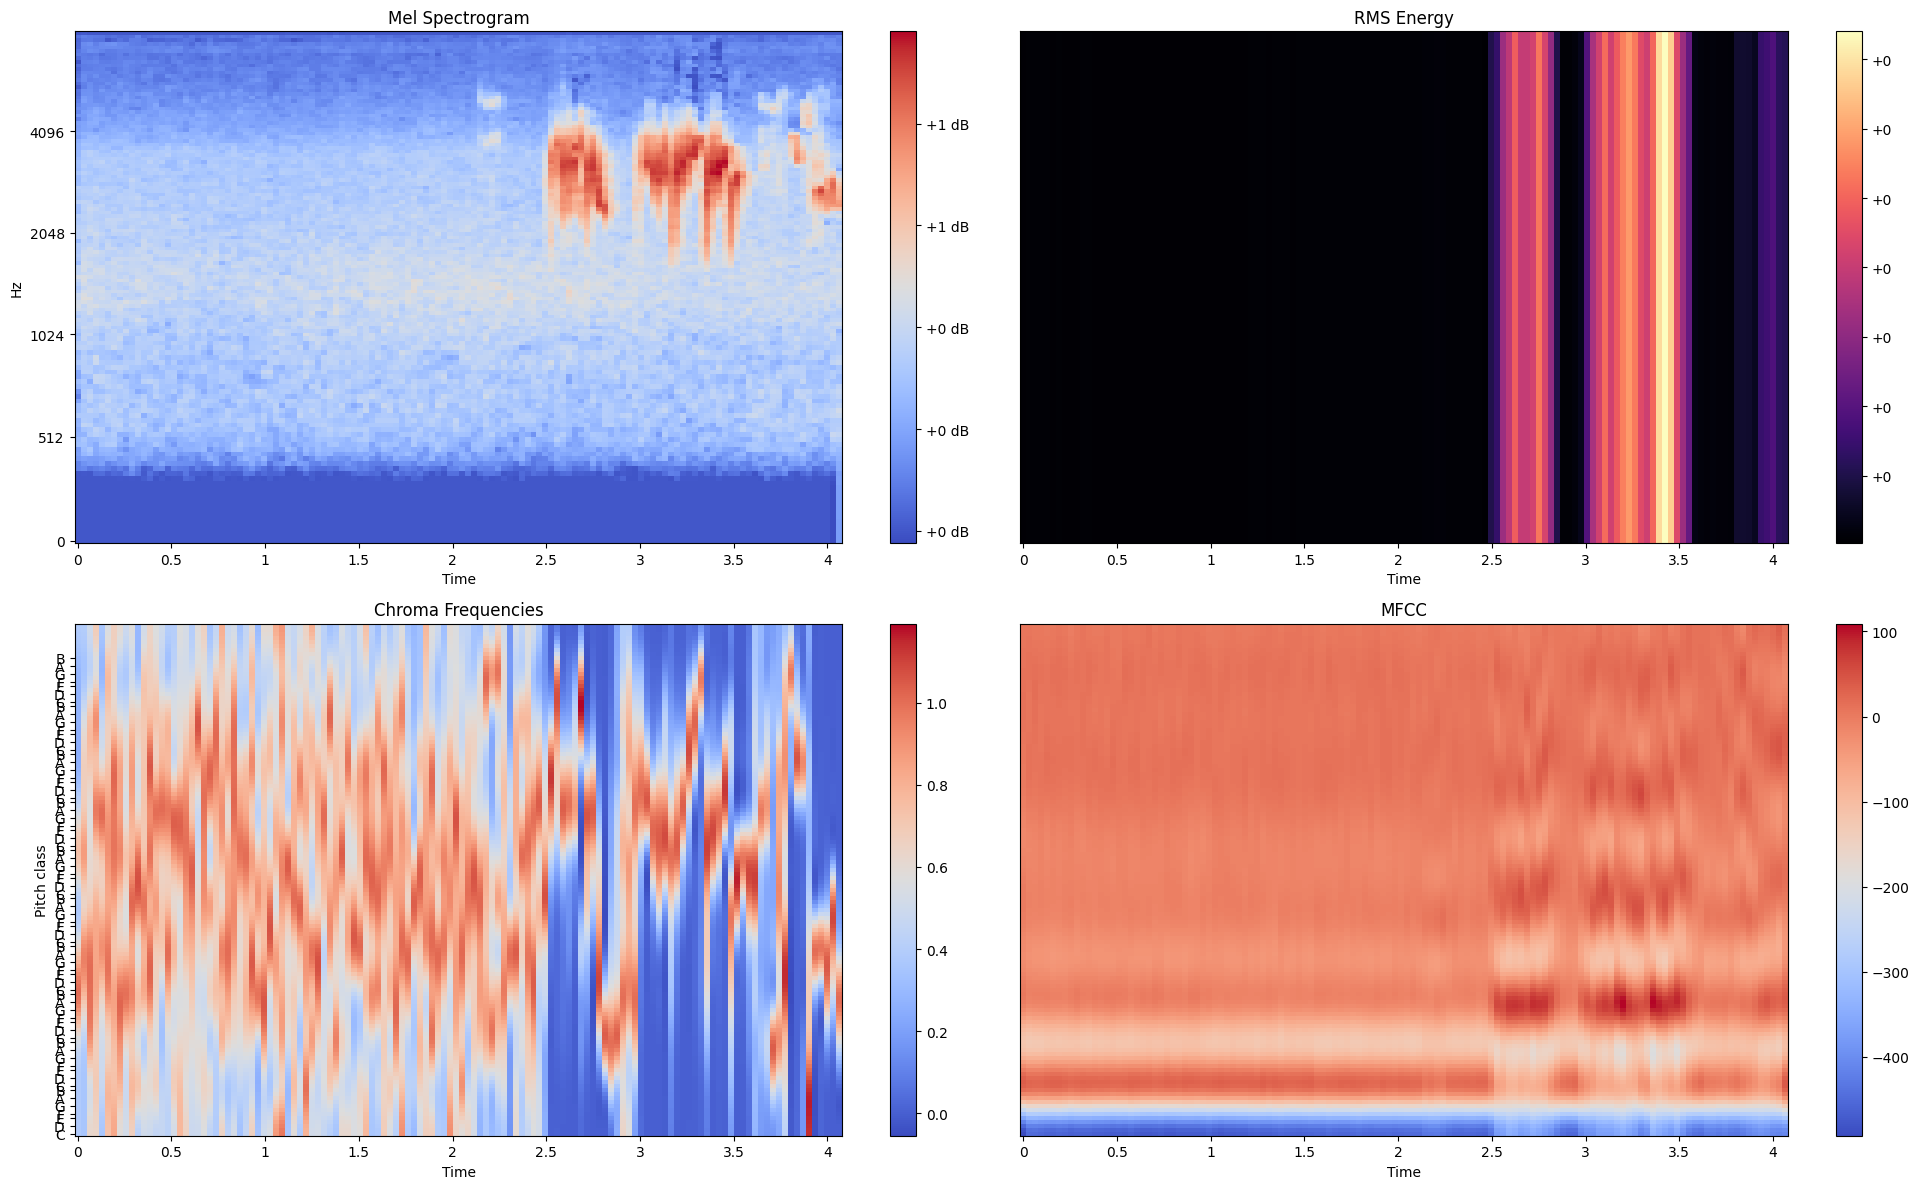

Playing audio window 4 from 12.00s to 18.00s:


In [12]:
npy_file = 'somgre1/XC154317.npy'
window_idx = 4
filter = True

plot_all_features(npy_file, window_idx, filter) # Plotting with the filter. 

## Processing the training data

In [15]:
train_features = {}
for _, row in tqdm(train_data.iterrows(), desc="Processing training features", total=len(train_data)):
    npy_file = row['filename_npy']
    label = row['primary_label']
    
    # Generate features for the file
    feature_windows = get_features_with_window(npy_file)
    if feature_windows is None:
        continue  # Skip short samples
    
    # Save each window's features in a dictionary along with the label
    for i, feature_set in enumerate(feature_windows):
        key = f"{npy_file}_window_{i}"
        train_features[key] = (feature_set, label)

Processing training features:   0%|          | 19/4176 [00:07<28:22,  2.44it/s]


KeyboardInterrupt: 

In [38]:
with open(train_pkl_path, 'wb') as f:
    pickle.dump(train_features, f)

## Processing the validation data

In [39]:
val_features = {}
for _, row in tqdm(val_data.iterrows(), desc="Processing training features", total=len(val_data)):
    npy_file = row['filename_npy']
    label = row['primary_label']
    
    # Generate features for the file
    feature_windows = get_features_with_window(npy_file)
    if feature_windows is None:
        continue  # Skip short samples
    
    # Save each window's features in a dictionary along with the label
    for i, feature_set in enumerate(feature_windows):
        key = f"{npy_file}_window_{i}"
        val_features[key] = (feature_set, label)

Processing training features: 100%|██████████| 835/835 [25:20<00:00,  1.82s/it]  


In [40]:
# Save validation mel spectrograms to pickle
with open(val_pkl_path, 'wb') as f:
    pickle.dump(val_features, f)

## Plotting the spectrograms

So you can see that its not really a good way to do it this way

In [87]:
def view_mel_spectrogram_by_index(train_mel_spectrograms, index, isTrain=True):
    # Get the key for the chosen index
    key = list(train_mel_spectrograms.keys())[index]
    
    temp_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V2/train_audio_npy/'
    

    
    # Extract mel spectrogram and label from the dictionary
    mel_spectrogram, label = train_mel_spectrograms[key]
    
    # Plot the Mel spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram.squeeze(), sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.title(f'Mel Spectrogram for {label} (Index: {index})')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

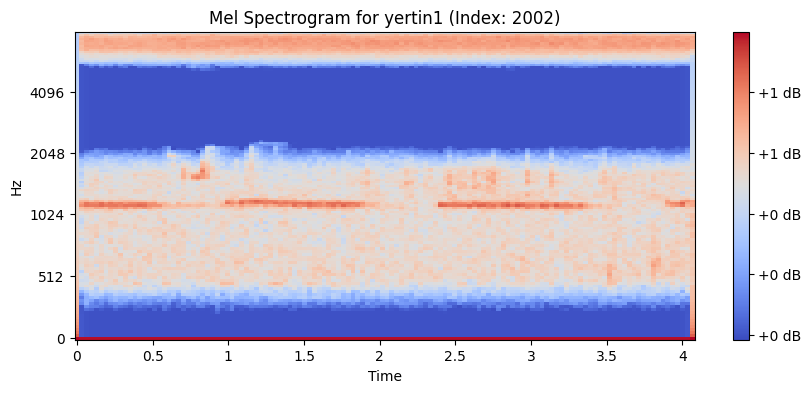

In [88]:
view_mel_spectrogram_by_index(train_mel_spectrograms, 2002)

# Confirming that the pickle files were saved correctly:

In [89]:
with open(train_pkl_path, 'rb') as f:
    train_mel_spectrograms_2 = pickle.load(f)

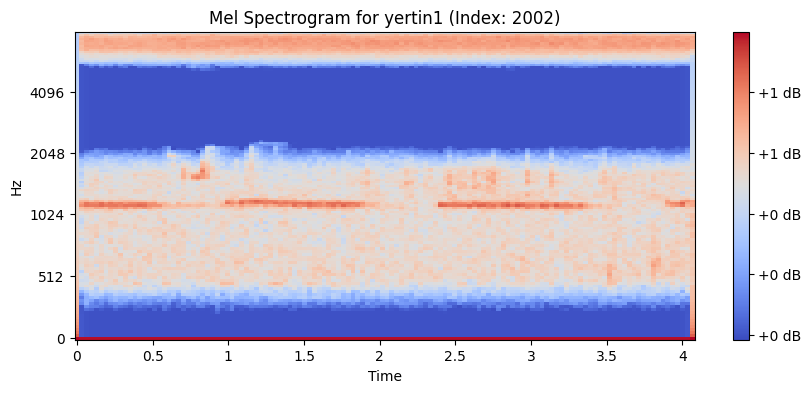

In [90]:
view_mel_spectrogram_by_index(train_mel_spectrograms_2, 2002)